# LightGCN V10b - Item-Item Co-occurrence Graph (Rating-aware)

## 핵심 개선사항 (V9b 대비)
- **Item-Item Graph**: Co-purchase 패턴 기반 item similarity graph 추가
- **Dual-Graph Architecture**: User-Item + Item-Item 두 그래프 동시 활용
- **Learnable Alpha**: UI/II graph mixing ratio 학습
- **Ground Truth**: Rating >= 4만 positive (V9b 유지)
- Hard Negative Mining + Rating Weighted Graph (V9b 유지)
- GPU 최적화 유지 (MPS/CUDA)

## 예상 효과
- Recall 향상: Item 간 직접 연결로 shortcut 제공
- Cold Item 개선: 유사 item 정보로 embedding 품질 향상
- 최고 성능 기대: V9b (0.9263 AUC) + II Graph

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time
from scipy import sparse

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# CUDA 우선
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. 데이터 전처리 (Rating-aware)

In [2]:
df = pd.read_csv('../data/train.csv')

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user'].nunique()}")
print(f"Unique items: {df['item'].nunique()}")

print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

# Good purchase definition
GOOD_RATING_THRESHOLD = 4
n_good_purchases = (df['rating'] >= GOOD_RATING_THRESHOLD).sum()
print(f"\nGood purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,} ({100*n_good_purchases/len(df):.1f}%)")

# ID mapping
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)

print(f"\nUsers: {n_users}, Items: {n_items}")

Total interactions: 105,139
Unique users: 668
Unique items: 10321

Rating distribution:
rating
0.5     1189
1.0     3254
1.5     1564
2.0     7929
2.5     5473
3.0    21676
3.5    12224
4.0    28831
4.5     8174
5.0    14825
Name: count, dtype: int64

Good purchases (rating >= 4): 51,830 (49.3%)

Users: 668, Items: 10321


In [3]:
# User별 interaction count 및 K값 계산
user_interaction_count = df.groupby('user_idx').size().to_dict()

MAX_K = 100

def get_k_for_user(count):
    if count <= 10:
        return 2
    k = max(2, int(count * 0.2))
    return min(k, MAX_K)

user_k = {u: get_k_for_user(c) for u, c in user_interaction_count.items()}

k_values = list(user_k.values())
print(f"User K values statistics (MAX_K={MAX_K}):")
print(f"  Min K: {min(k_values)}")
print(f"  Max K: {max(k_values)}")
print(f"  Mean K: {np.mean(k_values):.2f}")
print(f"  Median K: {np.median(k_values):.2f}")

User K values statistics (MAX_K=100):
  Min K: 4
  Max K: 100
  Mean K: 24.74
  Median K: 14.00


In [4]:
# Train/Val/Test Split (Rating-aware)
# Rating >= 4인 edge만 Val/Test로 분할
# Rating < 4인 edge는 모두 Train에 포함

train_data, val_data, test_data = [], [], []

for user_idx in range(n_users):
    user_df = df[df['user_idx'] == user_idx]
    
    good_purchases = user_df[user_df['rating'] >= GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    bad_purchases = user_df[user_df['rating'] < GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    
    # Bad purchases → Train (graph learning)
    if len(bad_purchases) > 0:
        train_data.append(bad_purchases[['user_idx', 'item_idx']])
    
    # Good purchases → Train/Val/Test split
    n_good = len(good_purchases)
    
    if n_good >= 3:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_end = int(0.7 * n_good)
        val_end = train_end + int(0.15 * n_good)
        
        train_end = max(1, train_end)
        val_end = max(train_end + 1, val_end)
        
        train_data.append(good_purchases.iloc[:train_end][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[train_end:val_end][['user_idx', 'item_idx']])
        test_data.append(good_purchases.iloc[val_end:][['user_idx', 'item_idx']])
    elif n_good == 2:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(good_purchases.iloc[:1][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[1:][['user_idx', 'item_idx']])
    elif n_good == 1:
        train_data.append(good_purchases[['user_idx', 'item_idx']])

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame(columns=['user_idx', 'item_idx'])
test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame(columns=['user_idx', 'item_idx'])

print(f"Train edges (all purchases for graph): {len(train_df):,}")
print(f"Val edges (good purchases only): {len(val_df):,}")
print(f"Test edges (good purchases only): {len(test_df):,}")

n_val_test = len(val_df) + len(test_df)
print(f"\nGood purchases in Val/Test: {n_val_test:,} / {n_good_purchases:,} ({100*n_val_test/n_good_purchases:.1f}%)")

Train edges (all purchases for graph): 89,294
Val edges (good purchases only): 7,480
Test edges (good purchases only): 8,365

Good purchases in Val/Test: 15,845 / 51,830 (30.6%)


In [5]:
# Pre-computed tensors
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)

user_train_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_train_items[int(u)].add(int(i))

print(f"Train tensors ready: {len(train_users):,} edges")

Train tensors ready: 89,294 edges


def build_item_item_graph(k_neighbors=10):
    """Item-Item similarity graph based on co-purchase patterns"""
    print(f"Building Item-Item graph (k={k_neighbors})...")
    
    from sklearn.metrics.pairwise import cosine_similarity
    
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    # Item-User co-occurrence matrix
    item_user_matrix = sparse.csr_matrix(
        (np.ones(len(train_df)), (items, users)),
        shape=(n_items, n_users)
    )
    
    # Cosine similarity
    print("  Computing item-item cosine similarity...")
    item_sim = cosine_similarity(item_user_matrix, dense_output=False)
    
    # k-NN graph
    print(f"  Building k-NN graph...")
    edges = []
    weights = []
    
    for i in range(n_items):
        sim_row = item_sim[i].toarray().flatten()
        sim_row[i] = -1  # Exclude self
        top_k_indices = np.argsort(sim_row)[-k_neighbors:]
        
        for j in top_k_indices:
            if sim_row[j] > 0:
                edges.append([i, j])
                weights.append(sim_row[j])
    
    if len(edges) == 0:
        print("  WARNING: No item-item edges created!")
        return torch.LongTensor([[],[]]), torch.FloatTensor([])
    
    edge_index = torch.LongTensor(edges).T
    edge_weight = torch.FloatTensor(weights)
    
    print(f"  Created {len(edges):,} item-item edges")
    print(f"  Weight range: [{edge_weight.min().item():.4f}, {edge_weight.max().item():.4f}]")
    print(f"  Mean weight: {edge_weight.mean().item():.4f}")
    
    return edge_index, edge_weight

# TUNING: k=5 (sparse), k=10 (default), k=15, k=20 (dense) 시도 가능
K_NEIGHBORS = 15  # 10에서 15로 증가
ii_edge_index, ii_edge_weight = build_item_item_graph(K_NEIGHBORS)

print(f"\nGraph Summary:")
print(f"  User-Item edges: {ui_edge_index.shape[1]:,}")
print(f"  Item-Item edges: {ii_edge_index.shape[1]:,}")

In [6]:
class DualGraphLightGCN(nn.Module):
    """LightGCN with User-Item and Item-Item graphs"""
    
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=2, alpha_init=0.5):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        # Embeddings
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        
        # Learnable mixing parameter for UI/II graphs
        # alpha_init을 logit으로 변환 (sigmoid의 역함수)
        import math
        alpha_logit = math.log(alpha_init / (1 - alpha_init))
        self.alpha = nn.Parameter(torch.tensor(alpha_logit))
    
    def ui_propagation(self, ui_edge_index, ui_edge_weight):
        """User-Item graph propagation"""
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = ui_edge_index
            messages = all_emb[col] * ui_edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]
    
    def ii_propagation(self, item_emb, ii_edge_index, ii_edge_weight):
        """Item-Item graph propagation (refine item embeddings)"""
        if ii_edge_index.shape[1] == 0:
            # No II edges, return original
            return item_emb
        
        embs = [item_emb]
        current_emb = item_emb
        
        for _ in range(self.n_layers):
            row, col = ii_edge_index
            
            # Symmetric normalization for II graph
            deg = torch.zeros(self.n_items, device=item_emb.device)
            deg = deg.scatter_add(0, row, torch.ones_like(row, dtype=torch.float))
            deg_inv_sqrt = deg.pow(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
            
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col] * ii_edge_weight
            
            messages = current_emb[col] * norm.unsqueeze(1)
            current_emb = torch.zeros_like(item_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(current_emb)
        
        return torch.mean(torch.stack(embs), dim=0)
    
    def forward(self, ui_edge_index, ui_edge_weight, ii_edge_index, ii_edge_weight):
        # 1. User-Item propagation
        u_emb, i_emb_ui = self.ui_propagation(ui_edge_index, ui_edge_weight)
        
        # 2. Item-Item propagation
        i_emb_ii = self.ii_propagation(self.item_emb.weight, ii_edge_index, ii_edge_weight)
        
        # 3. Adaptive mixing with constraint
        alpha_clamped = torch.sigmoid(self.alpha)
        # TUNING: UI graph를 최소 30%, 최대 70% 반영하도록 제한
        alpha_clamped = torch.clamp(alpha_clamped, min=0.3, max=0.7)
        i_emb_final = alpha_clamped * i_emb_ui + (1 - alpha_clamped) * i_emb_ii
        
        return u_emb, i_emb_final

def bpr_loss(pos_scores, neg_scores):
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

User-Item Graph: 178,588 edges
  Weight range: [0.0007, 0.2571]


### 2.2 Item-Item Co-occurrence Graph (NEW in V10)

In [7]:
def build_item_item_graph(k_neighbors=10):
    """Item-Item similarity graph based on co-purchase patterns"""
    print(f"Building Item-Item graph (k={k_neighbors})...")
    
    from sklearn.metrics.pairwise import cosine_similarity
    
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    # Item-User co-occurrence matrix
    item_user_matrix = sparse.csr_matrix(
        (np.ones(len(train_df)), (items, users)),
        shape=(n_items, n_users)
    )
    
    # Cosine similarity
    print("  Computing item-item cosine similarity...")
    item_sim = cosine_similarity(item_user_matrix, dense_output=False)
    
    # k-NN graph
    print(f"  Building k-NN graph...")
    edges = []
    weights = []
    
    for i in range(n_items):
        sim_row = item_sim[i].toarray().flatten()
        sim_row[i] = -1  # Exclude self
        top_k_indices = np.argsort(sim_row)[-k_neighbors:]
        
        for j in top_k_indices:
            if sim_row[j] > 0:
                edges.append([i, j])
                weights.append(sim_row[j])
    
    if len(edges) == 0:
        print("  WARNING: No item-item edges created!")
        return torch.LongTensor([[],[]]), torch.FloatTensor([])
    
    edge_index = torch.LongTensor(edges).T
    edge_weight = torch.FloatTensor(weights)
    
    print(f"  Created {len(edges):,} item-item edges")
    print(f"  Weight range: [{edge_weight.min().item():.4f}, {edge_weight.max().item():.4f}]")
    print(f"  Mean weight: {edge_weight.mean().item():.4f}")
    
    return edge_index, edge_weight

K_NEIGHBORS = 10
ii_edge_index, ii_edge_weight = build_item_item_graph(K_NEIGHBORS)

print(f"\nGraph Summary:")
print(f"  User-Item edges: {ui_edge_index.shape[1]:,}")
print(f"  Item-Item edges: {ii_edge_index.shape[1]:,}")

Building Item-Item graph (k=10)...
  Computing item-item cosine similarity...
  Building k-NN graph...
  Created 100,360 item-item edges
  Weight range: [0.1125, 1.0000]
  Mean weight: 0.7489

Graph Summary:
  User-Item edges: 178,588
  Item-Item edges: 100,360


## 3. Dual-Graph LightGCN Model

In [8]:
class DualGraphLightGCN(nn.Module):
    """LightGCN with User-Item and Item-Item graphs"""
    
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        
        # Learnable mixing parameter
        self.alpha = nn.Parameter(torch.tensor(0.5))
    
    def ui_propagation(self, ui_edge_index, ui_edge_weight):
        """User-Item graph propagation"""
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = ui_edge_index
            messages = all_emb[col] * ui_edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]
    
    def ii_propagation(self, item_emb, ii_edge_index, ii_edge_weight):
        """Item-Item graph propagation"""
        if ii_edge_index.shape[1] == 0:
            return item_emb
        
        embs = [item_emb]
        current_emb = item_emb
        
        for _ in range(self.n_layers):
            row, col = ii_edge_index
            
            # Symmetric normalization
            deg = torch.zeros(self.n_items, device=item_emb.device)
            deg = deg.scatter_add(0, row, torch.ones_like(row, dtype=torch.float))
            deg_inv_sqrt = deg.pow(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
            
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col] * ii_edge_weight
            
            messages = current_emb[col] * norm.unsqueeze(1)
            current_emb = torch.zeros_like(item_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(current_emb)
        
        return torch.mean(torch.stack(embs), dim=0)
    
    def forward(self, ui_edge_index, ui_edge_weight, ii_edge_index, ii_edge_weight):
        # 1. User-Item propagation
        u_emb, i_emb_ui = self.ui_propagation(ui_edge_index, ui_edge_weight)
        
        # 2. Item-Item propagation
        i_emb_ii = self.ii_propagation(self.item_emb.weight, ii_edge_index, ii_edge_weight)
        
        # 3. Adaptive mixing
        alpha_clamped = torch.sigmoid(self.alpha)
        i_emb_final = alpha_clamped * i_emb_ui + (1 - alpha_clamped) * i_emb_ii
        
        return u_emb, i_emb_final

def bpr_loss(pos_scores, neg_scores):
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

# Move graphs to device
ui_edge_index = ui_edge_index.to(device)
ui_edge_weight = ui_edge_weight.to(device)
ii_edge_index = ii_edge_index.to(device)
ii_edge_weight = ii_edge_weight.to(device)

# TUNING: alpha_init=0.5 (균형), 0.6 (UI 중심), 0.4 (II 중심) 시도 가능
ALPHA_INIT = 0.5  # UI/II 균형 시작점
model = DualGraphLightGCN(n_users, n_items, EMB_DIM, N_LAYERS, alpha_init=ALPHA_INIT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

print(f"Alpha initialized: {ALPHA_INIT:.2f} (UI weight, constrained to 0.3~0.7)")

history = {'loss': [], 'precision': [], 'recall': [], 'hit': [], 'alpha': []}
best_recall = 0
n_train = len(train_users)

train_u_gpu = train_users.to(device)
train_i_gpu = train_items.to(device)

print(f"\nTraining Dual-Graph LightGCN (Rating-aware)...")
print("=" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(n_train, device=device)
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, n_train, BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_u_gpu[batch_idx]
        pos_i = train_i_gpu[batch_idx]
        
        # Forward with dual graphs
        u_emb, i_emb = model(ui_edge_index, ui_edge_weight, ii_edge_index, ii_edge_weight)
        
        # Hard Negative Mining + Random
        if USE_HARD_NEGATIVE:
            n_hard = int(NUM_NEG * HARD_NEG_RATIO)
            n_random = NUM_NEG - n_hard
            
            if n_hard > 0:
                hard_negs = hard_negative_sampling(u_emb, i_emb, pos_u, num_neg=n_hard)
            else:
                hard_negs = None
            
            if n_random > 0:
                random_negs = fast_sample_negatives(len(batch_idx), n_random).to(device)
            else:
                random_negs = None
            
            if hard_negs is not None and random_negs is not None:
                neg_i = torch.cat([hard_negs, random_negs], dim=1)
            elif hard_negs is not None:
                neg_i = hard_negs
            else:
                neg_i = random_negs
        else:
            neg_i = fast_sample_negatives(len(batch_idx), NUM_NEG).to(device)
        
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_scores = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
        
        loss = bpr_loss(pos_scores, neg_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    history['loss'].append(epoch_loss / n_batches)
    
    # Track alpha (actual value after clamping)
    with torch.no_grad():
        alpha_raw = torch.sigmoid(model.alpha).item()
        alpha_clamped = torch.clamp(torch.sigmoid(model.alpha), min=0.3, max=0.7).item()
    history['alpha'].append(alpha_clamped)
    
    if (epoch + 1) % 5 == 0:
        prec, rec, hit = evaluate_user_wise_topk(
            model, val_df, ui_edge_index, ui_edge_weight, 
            ii_edge_index, ii_edge_weight, sample_users=200
        )
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['hit'].append(hit)
        
        print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} | "
              f"Prec@K: {prec:.4f} | Recall@K: {rec:.4f} | Hit@K: {hit:.4f} | "
              f"Alpha: {alpha_clamped:.3f} (raw: {alpha_raw:.3f})")
        
        if rec > best_recall:
            best_recall = rec
            torch.save(model.state_dict(), 'best_lightgcn_v10b.pt')

elapsed = time.time() - start_time
print(f"\nTraining time: {elapsed/60:.1f} minutes")
print(f"Best Recall@K: {best_recall:.4f}")
final_alpha_raw = torch.sigmoid(model.alpha).item()
final_alpha_clamped = torch.clamp(torch.sigmoid(model.alpha), min=0.3, max=0.7).item()
print(f"Final Alpha: {final_alpha_clamped:.3f} (raw: {final_alpha_raw:.3f})")

In [9]:
def fast_sample_negatives(batch_size, num_neg=4):
    neg_items = torch.randint(0, n_items, (batch_size, num_neg))
    return neg_items

@torch.no_grad()
def hard_negative_sampling(user_emb, item_emb, pos_users, num_neg=4, num_candidates=50):
    batch_size = len(pos_users)
    candidates = torch.randint(0, n_items, (batch_size, num_candidates), device=device)
    
    user_expanded = user_emb[pos_users].unsqueeze(1)
    item_candidates = item_emb[candidates]
    scores = (user_expanded * item_candidates).sum(dim=2)
    
    _, top_indices = scores.topk(num_neg, dim=1)
    hard_negs = candidates.gather(1, top_indices)
    
    return hard_negs

USE_HARD_NEGATIVE = True
HARD_NEG_RATIO = 0.5

print(f"Negative Sampling: {'Hard Negative Mining' if USE_HARD_NEGATIVE else 'Random'}")
if USE_HARD_NEGATIVE:
    print(f"  Hard/Random ratio: {HARD_NEG_RATIO:.0%} / {1-HARD_NEG_RATIO:.0%}")

Negative Sampling: Hard Negative Mining
  Hard/Random ratio: 50% / 50%


In [10]:
@torch.no_grad()
def evaluate_user_wise_topk(model, eval_df, ui_ei, ui_ew, ii_ei, ii_ew, sample_users=100):
    model.eval()
    u_emb, i_emb = model(ui_ei, ui_ew, ii_ei, ii_ew)
    
    eval_users = eval_df['user_idx'].unique()
    if len(eval_users) > sample_users:
        eval_users = np.random.choice(eval_users, sample_users, replace=False)
    
    precisions, recalls, hits = [], [], []
    
    for user_idx in eval_users:
        actual_items = set(eval_df[eval_df['user_idx'] == user_idx]['item_idx'].values)
        if len(actual_items) == 0:
            continue
        
        train_items_set = user_train_items[int(user_idx)]
        candidate_items = [i for i in range(n_items) if i not in train_items_set]
        if len(candidate_items) == 0:
            continue
        
        candidate_tensor = torch.LongTensor(candidate_items).to(device)
        user_tensor = torch.full((len(candidate_items),), user_idx, dtype=torch.long, device=device)
        scores = (u_emb[user_tensor] * i_emb[candidate_tensor]).sum(dim=1)
        
        K = user_k[int(user_idx)]
        K = min(K, len(candidate_items))
        
        _, top_k_indices = torch.topk(scores, K)
        top_k_items = set([candidate_items[idx.item()] for idx in top_k_indices])
        
        hits_count = len(top_k_items & actual_items)
        precision = hits_count / K if K > 0 else 0
        recall = hits_count / len(actual_items) if len(actual_items) > 0 else 0
        hit = 1.0 if hits_count > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        hits.append(hit)
    
    return np.mean(precisions), np.mean(recalls), np.mean(hits)

In [11]:
# Training config
EMB_DIM = 32
N_LAYERS = 2
LR = 5e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 50
BATCH_SIZE = 1024
NUM_NEG = 4

print(f"Training config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  k_neighbors (II): {K_NEIGHBORS}")
print(f"  lr: {LR}")
print(f"  epochs: {EPOCHS}")

Training config:
  emb_dim: 32
  n_layers: 2
  k_neighbors (II): 10
  lr: 0.005
  epochs: 50


In [12]:
# Move graphs to device
ui_edge_index = ui_edge_index.to(device)
ui_edge_weight = ui_edge_weight.to(device)
ii_edge_index = ii_edge_index.to(device)
ii_edge_weight = ii_edge_weight.to(device)

model = DualGraphLightGCN(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {'loss': [], 'precision': [], 'recall': [], 'hit': [], 'alpha': []}
best_recall = 0
n_train = len(train_users)

train_u_gpu = train_users.to(device)
train_i_gpu = train_items.to(device)

print(f"\nTraining Dual-Graph LightGCN (Rating-aware)...")
print("=" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(n_train, device=device)
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, n_train, BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_u_gpu[batch_idx]
        pos_i = train_i_gpu[batch_idx]
        
        # Forward with dual graphs
        u_emb, i_emb = model(ui_edge_index, ui_edge_weight, ii_edge_index, ii_edge_weight)
        
        # Hard Negative Mining + Random
        if USE_HARD_NEGATIVE:
            n_hard = int(NUM_NEG * HARD_NEG_RATIO)
            n_random = NUM_NEG - n_hard
            
            if n_hard > 0:
                hard_negs = hard_negative_sampling(u_emb, i_emb, pos_u, num_neg=n_hard)
            else:
                hard_negs = None
            
            if n_random > 0:
                random_negs = fast_sample_negatives(len(batch_idx), n_random).to(device)
            else:
                random_negs = None
            
            if hard_negs is not None and random_negs is not None:
                neg_i = torch.cat([hard_negs, random_negs], dim=1)
            elif hard_negs is not None:
                neg_i = hard_negs
            else:
                neg_i = random_negs
        else:
            neg_i = fast_sample_negatives(len(batch_idx), NUM_NEG).to(device)
        
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_scores = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
        
        loss = bpr_loss(pos_scores, neg_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    history['loss'].append(epoch_loss / n_batches)
    
    # Track alpha
    alpha_value = torch.sigmoid(model.alpha).item()
    history['alpha'].append(alpha_value)
    
    if (epoch + 1) % 5 == 0:
        prec, rec, hit = evaluate_user_wise_topk(
            model, val_df, ui_edge_index, ui_edge_weight, 
            ii_edge_index, ii_edge_weight, sample_users=200
        )
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['hit'].append(hit)
        
        print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} | "
              f"Prec@K: {prec:.4f} | Recall@K: {rec:.4f} | Hit@K: {hit:.4f} | "
              f"Alpha: {alpha_value:.3f}")
        
        if rec > best_recall:
            best_recall = rec
            torch.save(model.state_dict(), 'best_lightgcn_v10b.pt')

elapsed = time.time() - start_time
print(f"\nTraining time: {elapsed/60:.1f} minutes")
print(f"Best Recall@K: {best_recall:.4f}")
print(f"Final Alpha: {torch.sigmoid(model.alpha).item():.3f}")


Training Dual-Graph LightGCN (Rating-aware)...
Epoch   5 | Loss: 0.5436 | Prec@K: 0.0490 | Recall@K: 0.1210 | Hit@K: 0.5050 | Alpha: 0.206
Epoch  10 | Loss: 0.5193 | Prec@K: 0.0641 | Recall@K: 0.1630 | Hit@K: 0.5500 | Alpha: 0.092
Epoch  15 | Loss: 0.5099 | Prec@K: 0.0627 | Recall@K: 0.1615 | Hit@K: 0.5550 | Alpha: 0.051
Epoch  20 | Loss: 0.5045 | Prec@K: 0.0701 | Recall@K: 0.1766 | Hit@K: 0.6100 | Alpha: 0.032
Epoch  25 | Loss: 0.5013 | Prec@K: 0.0782 | Recall@K: 0.1969 | Hit@K: 0.5900 | Alpha: 0.023
Epoch  30 | Loss: 0.4988 | Prec@K: 0.0737 | Recall@K: 0.1852 | Hit@K: 0.6000 | Alpha: 0.017
Epoch  35 | Loss: 0.4965 | Prec@K: 0.0603 | Recall@K: 0.1687 | Hit@K: 0.5100 | Alpha: 0.013
Epoch  40 | Loss: 0.4959 | Prec@K: 0.0699 | Recall@K: 0.1949 | Hit@K: 0.5600 | Alpha: 0.010
Epoch  45 | Loss: 0.4944 | Prec@K: 0.0674 | Recall@K: 0.1790 | Hit@K: 0.5600 | Alpha: 0.008
Epoch  50 | Loss: 0.4938 | Prec@K: 0.0671 | Recall@K: 0.1728 | Hit@K: 0.5800 | Alpha: 0.007

Training time: 7.3 minutes
Best

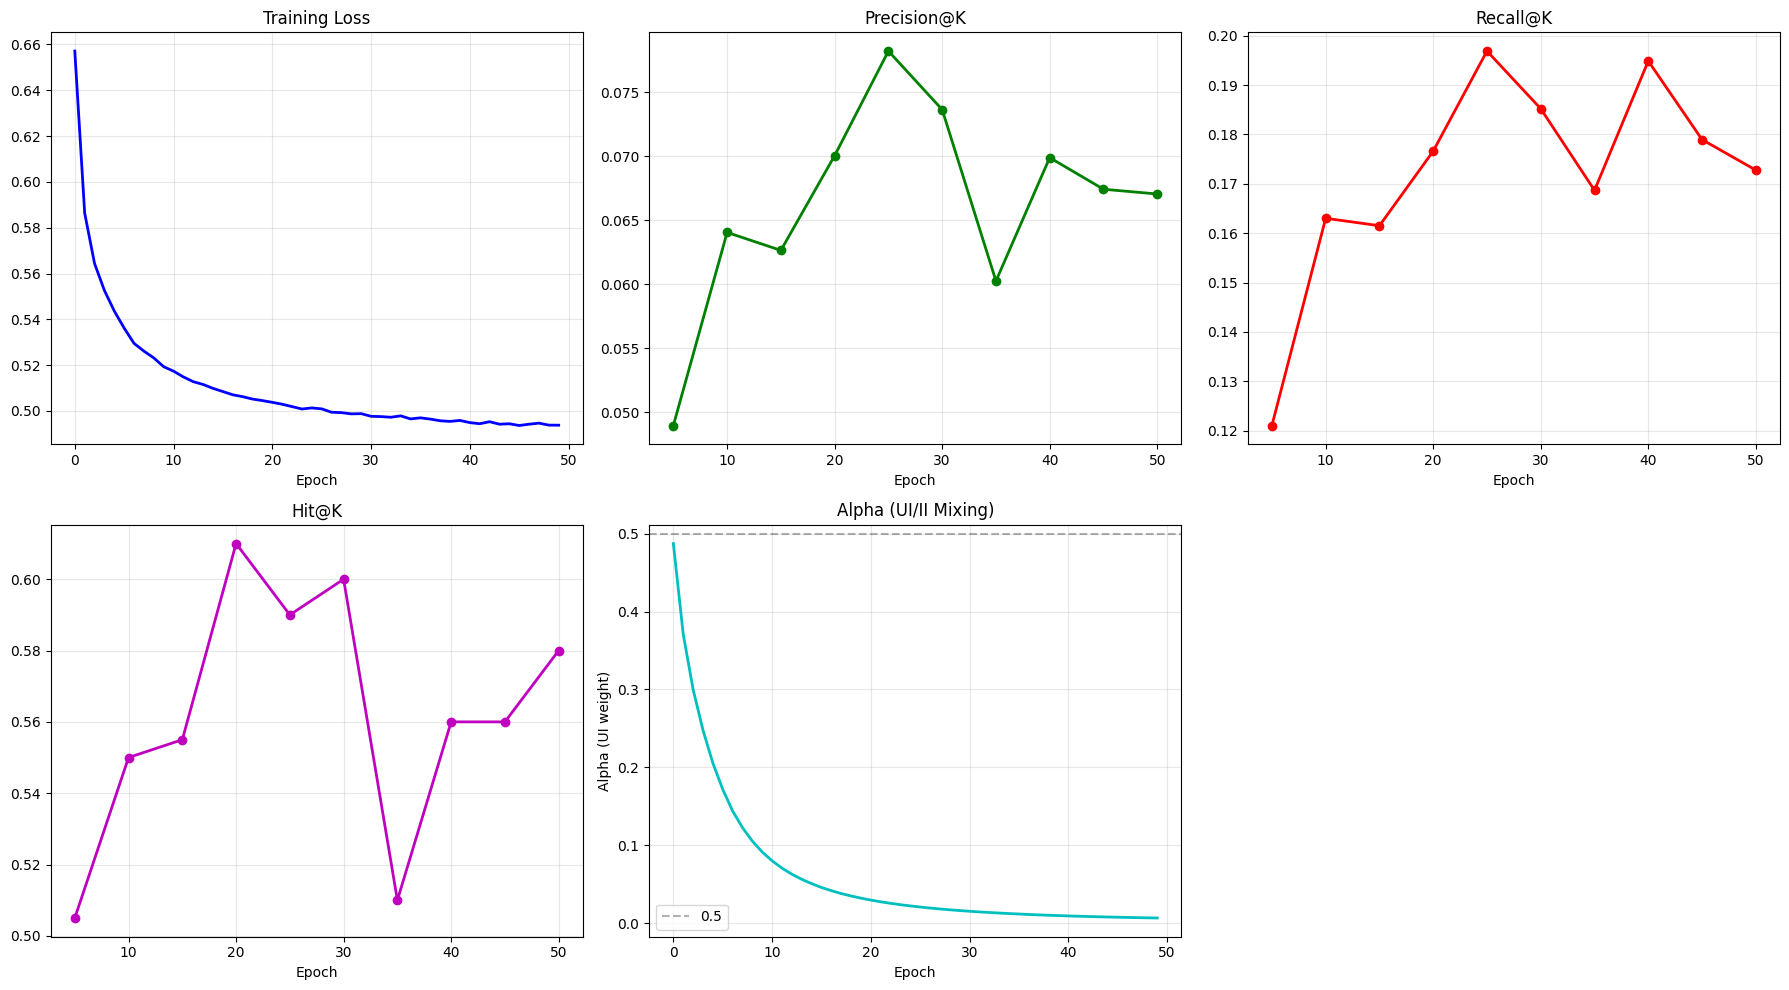

In [13]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history['loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(alpha=0.3)

epochs_val = np.arange(5, EPOCHS+1, 5)[:len(history['precision'])]
axes[0, 1].plot(epochs_val, history['precision'], 'g-o', linewidth=2)
axes[0, 1].set_title('Precision@K')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].grid(alpha=0.3)

axes[0, 2].plot(epochs_val, history['recall'], 'r-o', linewidth=2)
axes[0, 2].set_title('Recall@K')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].grid(alpha=0.3)

axes[1, 0].plot(epochs_val, history['hit'], 'm-o', linewidth=2)
axes[1, 0].set_title('Hit@K')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].grid(alpha=0.3)

# Alpha evolution
axes[1, 1].plot(history['alpha'], 'c-', linewidth=2)
axes[1, 1].set_title('Alpha (UI/II Mixing)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Alpha (UI weight)')
axes[1, 1].axhline(y=0.5, color='k', linestyle='--', alpha=0.3, label='0.5')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 5. Test Set Evaluation

In [14]:
# Load best model
model.load_state_dict(torch.load('best_lightgcn_v10b.pt'))
model.eval()

with torch.no_grad():
    u_emb, i_emb = model(ui_edge_index, ui_edge_weight, ii_edge_index, ii_edge_weight)

# Test Top-K (reference)
test_prec, test_rec, test_hit = evaluate_user_wise_topk(
    model, test_df, ui_edge_index, ui_edge_weight,
    ii_edge_index, ii_edge_weight, sample_users=500
)

print("Test Set Performance (User-wise Top-K only):")
print(f"  Precision@K: {test_prec:.4f}")
print(f"  Recall@K: {test_rec:.4f}")
print(f"  Hit@K: {test_hit:.4f}")

Test Set Performance (User-wise Top-K only):
  Precision@K: 0.0994
  Recall@K: 0.2027
  Hit@K: 0.6340


In [15]:
# AUC-ROC Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

print("Calculating AUC-ROC...")

# Val positive scores
val_u_gpu = torch.LongTensor(val_df['user_idx'].values).to(device)
val_i_gpu = torch.LongTensor(val_df['item_idx'].values).to(device)
val_pos_scores = (u_emb[val_u_gpu] * i_emb[val_i_gpu]).sum(dim=1).cpu().numpy()

# Val/Test edges for exclusion
val_test_edges = set()
for u, i in zip(val_df['user_idx'].values, val_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))
for u, i in zip(test_df['user_idx'].values, test_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))

# Val negative sampling
n_neg_samples = len(val_df)
neg_users, neg_items = [], []
sample_count = 0
while sample_count < n_neg_samples:
    user_idx = np.random.randint(0, n_users)
    item_idx = np.random.randint(0, n_items)
    if item_idx not in user_train_items[user_idx] and (user_idx, item_idx) not in val_test_edges:
        neg_users.append(user_idx)
        neg_items.append(item_idx)
        sample_count += 1

neg_u_gpu = torch.LongTensor(neg_users).to(device)
neg_i_gpu = torch.LongTensor(neg_items).to(device)
val_neg_scores = (u_emb[neg_u_gpu] * i_emb[neg_i_gpu]).sum(dim=1).cpu().numpy()

# AUC-ROC
all_scores = np.concatenate([val_pos_scores, val_neg_scores])
all_labels = np.concatenate([np.ones(len(val_pos_scores)), np.zeros(len(val_neg_scores))])

val_auc_roc = roc_auc_score(all_labels, all_scores)
print(f"\nValidation AUC-ROC: {val_auc_roc:.4f}")

# Score distributions
print(f"\nScore distributions:")
print(f"  Positive: mean={val_pos_scores.mean():.4f}, std={val_pos_scores.std():.4f}")
print(f"  Negative: mean={val_neg_scores.mean():.4f}, std={val_neg_scores.std():.4f}")
print(f"  Gap: {val_pos_scores.mean() - val_neg_scores.mean():.4f}")

Calculating AUC-ROC...

Validation AUC-ROC: 0.9220

Score distributions:
  Positive: mean=0.6892, std=0.7471
  Negative: mean=-0.6876, std=1.2469
  Gap: 1.3768


Finding optimal threshold...

Optimal Threshold:
  Threshold: 0.2186
  Precision: 0.8610
  Recall: 0.8738
  F1 Score: 0.8674
  O ratio: 50.7%


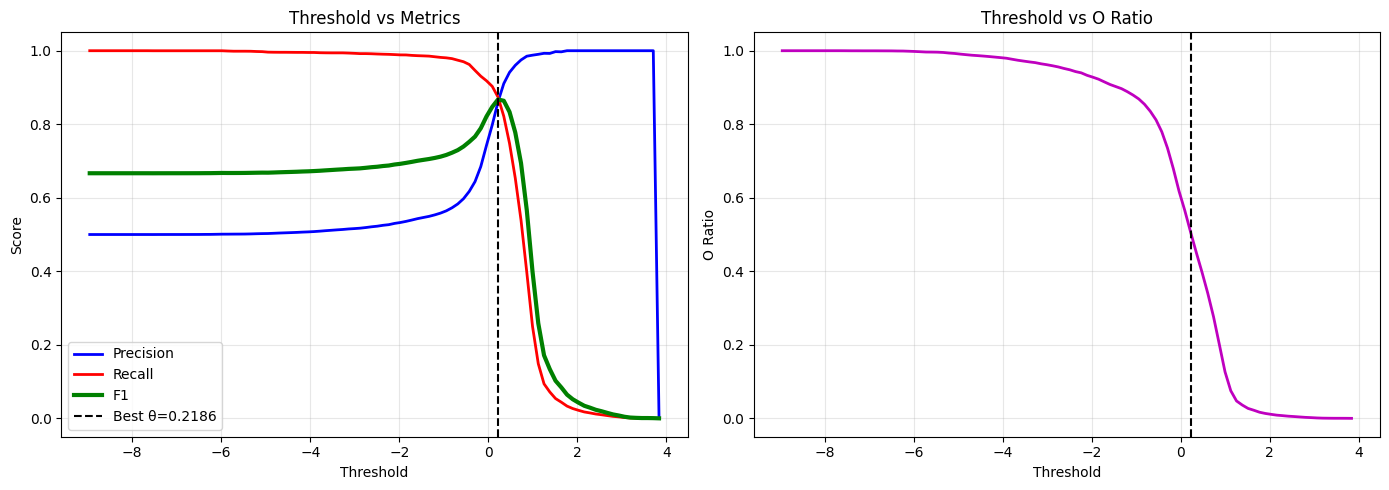

In [16]:
# Threshold tuning (F1 maximization)
print("Finding optimal threshold...")

thresholds = np.linspace(all_scores.min(), all_scores.max(), 100)
best_f1, best_th = 0, 0
best_prec, best_rec = 0, 0

results_list = []
for th in thresholds:
    preds = (all_scores > th).astype(int)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    o_ratio = preds.mean()
    
    results_list.append({
        'threshold': th,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'o_ratio': o_ratio
    })
    
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
        best_prec = prec
        best_rec = rec

print(f"\nOptimal Threshold:")
print(f"  Threshold: {best_th:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  Recall: {best_rec:.4f}")
print(f"  F1 Score: {best_f1:.4f}")

preds_at_best = (all_scores > best_th).astype(int)
o_ratio_best = preds_at_best.mean()
print(f"  O ratio: {o_ratio_best*100:.1f}%")

OPTIMAL_THRESHOLD = best_th

# Visualization
results_df = pd.DataFrame(results_list)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['recall'], 'r-', label='Recall', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['f1'], 'g-', label='F1', linewidth=3)
axes[0].axvline(x=best_th, color='k', linestyle='--', label=f'Best θ={best_th:.4f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Threshold vs Metrics')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(results_df['threshold'], results_df['o_ratio'], 'm-', linewidth=2)
axes[1].axvline(x=best_th, color='k', linestyle='--')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('O Ratio')
axes[1].set_title('Threshold vs O Ratio')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Test Set AUC-ROC
print("Calculating Test Set AUC-ROC...")

test_u_gpu = torch.LongTensor(test_df['user_idx'].values).to(device)
test_i_gpu = torch.LongTensor(test_df['item_idx'].values).to(device)
test_pos_scores = (u_emb[test_u_gpu] * i_emb[test_i_gpu]).sum(dim=1).cpu().numpy()

n_test_neg = len(test_df)
test_neg_scores = []
for _ in range(n_test_neg):
    user_idx = np.random.randint(0, n_users)
    item_idx = np.random.randint(0, n_items)
    while (item_idx in user_train_items[user_idx] or (user_idx, item_idx) in val_test_edges):
        item_idx = np.random.randint(0, n_items)
    score = (u_emb[user_idx] * i_emb[item_idx]).sum().item()
    test_neg_scores.append(score)

test_neg_scores = np.array(test_neg_scores)

test_all_scores = np.concatenate([test_pos_scores, test_neg_scores])
test_all_labels = np.concatenate([np.ones(len(test_pos_scores)), np.zeros(len(test_neg_scores))])

test_auc_roc = roc_auc_score(test_all_labels, test_all_scores)

print(f"\nTest Set AUC-ROC: {test_auc_roc:.4f}")
print(f"Validation AUC-ROC: {val_auc_roc:.4f}")

# Test metrics with threshold
test_preds = (test_all_scores > OPTIMAL_THRESHOLD).astype(int)
test_acc = (test_preds == test_all_labels).mean()
test_prec_th = precision_score(test_all_labels, test_preds, zero_division=0)
test_rec_th = recall_score(test_all_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_all_labels, test_preds, zero_division=0)
test_o_ratio = test_preds.mean()

print(f"\nTest Set with Threshold={OPTIMAL_THRESHOLD:.4f}:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  O Ratio: {test_o_ratio*100:.1f}%")

Calculating Test Set AUC-ROC...

Test Set AUC-ROC: 0.9268
Validation AUC-ROC: 0.9220

Test Set with Threshold=0.2186:
  Accuracy: 0.8709
  Precision: 0.8618
  Recall: 0.8834
  F1 Score: 0.8725
  O Ratio: 51.3%


## 6. Results Summary

In [19]:
def predict_hybrid(test_input_df, threshold):
    """
    Hybrid 추천: Threshold + Top-K 제약 (Rating-aware)
    1. Score > threshold인 item만 후보로 선택
    2. 후보 중 Top-K만 O (0~K개 추천)
    3. rating < GOOD_RATING_THRESHOLD 입력은 무조건 X (평가 기준 정합성)
    """
    with torch.no_grad():
        u_emb, i_emb = model(ui_edge_index, ui_edge_weight, ii_edge_index, ii_edge_weight)

    results = []
    stats = {'total_o': 0, 'total_items': 0, 'users_with_o': 0}

    # User별로 처리
    for user in test_input_df['user'].unique():
        if user not in user2idx:
            # Unknown user: 모두 X
            user_rows = test_input_df[test_input_df['user'] == user]
            for _, row in user_rows.iterrows():
                results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
                stats['total_items'] += 1
            continue

        user_idx = user2idx[user]
        user_rows = test_input_df[test_input_df['user'] == user]

        # User가 이미 선택한 items
        train_items_set = user_train_items[user_idx]

        # Test에서 주어진 items scoring
        items_to_score = []
        item_info = []  # (original_item, item_idx)

        for _, row in user_rows.iterrows():
            rating = row['rating'] if 'rating' in row else None
            # rating-aware: 평가 기준에 맞춰 낮은 평점 입력은 바로 X
            if rating is not None and rating < GOOD_RATING_THRESHOLD:
                results.append({'user': user, 'item': row['item'], 'recommend': 'X'})
                stats['total_items'] += 1
                continue

            item = row['item']
            if item not in item2idx:
                # Unknown item: X
                results.append({'user': user, 'item': item, 'recommend': 'X'})
                stats['total_items'] += 1
            elif item2idx[item] in train_items_set:
                # 이미 선택한 item: X (추천 불가)
                results.append({'user': user, 'item': item, 'recommend': 'X'})
                stats['total_items'] += 1
            else:
                items_to_score.append(item2idx[item])
                item_info.append(item)

        if len(items_to_score) == 0:
            continue

        # Score items
        item_tensor = torch.LongTensor(items_to_score).to(device)
        user_tensor = torch.full((len(items_to_score),), user_idx, dtype=torch.long, device=device)
        scores = (u_emb[user_tensor] * i_emb[item_tensor]).sum(dim=1).cpu().numpy()

        # Hybrid selection:
        # Step 1: Filter by threshold
        above_threshold_mask = scores > threshold
        above_threshold_indices = np.where(above_threshold_mask)[0]

        # Step 2: Top-K selection among threshold-passing items
        K = user_k[user_idx]

        if len(above_threshold_indices) > K:
            # Threshold 넘는게 K개 초과 → Top-K만 선택
            above_scores = scores[above_threshold_indices]
            top_k_in_above = np.argsort(above_scores)[-K:]
            selected_indices = set(above_threshold_indices[top_k_in_above])
        else:
            # Threshold 넘는게 K개 이하 → 모두 선택
            selected_indices = set(above_threshold_indices)

        # Mark O/X
        user_o_count = 0
        for i, item in enumerate(item_info):
            if i in selected_indices:
                recommend = 'O'
                user_o_count += 1
            else:
                recommend = 'X'
            results.append({'user': user, 'item': item, 'recommend': recommend})
            stats['total_items'] += 1

        stats['total_o'] += user_o_count
        if user_o_count > 0:
            stats['users_with_o'] += 1

    results_df = pd.DataFrame(results)
    return results_df, stats

In [20]:
print("=" * 70)
print("LightGCN V10b - Item-Item Graph (Rating-aware, TUNED)")
print("=" * 70)

print(f"\nModel Config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  k_neighbors (II): {K_NEIGHBORS}")
print(f"  alpha_init: {ALPHA_INIT}")
print(f"  alpha_constraint: [0.3, 0.7]")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nNew Features (V9b 대비):")
print(f"  • Item-Item Graph: {ii_edge_index.shape[1]:,} edges")
print(f"  • Dual-Graph Architecture: UI + II")
final_alpha_raw = torch.sigmoid(model.alpha).item()
final_alpha_clamped = torch.clamp(torch.sigmoid(model.alpha), min=0.3, max=0.7).item()
print(f"  • Learned Alpha: {final_alpha_clamped:.3f} (raw: {final_alpha_raw:.3f})")
print(f"    → UI graph: {final_alpha_clamped*100:.1f}%, II graph: {(1-final_alpha_clamped)*100:.1f}%")
if final_alpha_raw < 0.3:
    print(f"    ⚠️  Raw alpha {final_alpha_raw:.3f} < 0.3 (clamped to 0.3)")
elif final_alpha_raw > 0.7:
    print(f"    ⚠️  Raw alpha {final_alpha_raw:.3f} > 0.7 (clamped to 0.7)")
else:
    print(f"    ✓ Alpha within bounds (no clamping)")

print(f"\nData:")
print(f"  Good purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,}")
print(f"  Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

print(f"\nTest Performance:")
print(f"  AUC-ROC: {test_auc_roc:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

print(f"\nComparison with V9b:")
v9b_auc = 0.9263
v9b_f1 = 0.8719
v9b_rec = 0.8794
print(f"  V9b  AUC: {v9b_auc:.4f} | F1: {v9b_f1:.4f} | Recall: {v9b_rec:.4f}")
print(f"  V10b AUC: {test_auc_roc:.4f} | F1: {test_f1:.4f} | Recall: {test_rec_th:.4f}")
print(f"  Delta:    {(test_auc_roc - v9b_auc)*100:+.2f}%  | {(test_f1 - v9b_f1)*100:+.2f}%  | {(test_rec_th - v9b_rec)*100:+.2f}%")

V10b Sample Prediction (sample1.csv)
Threshold: 0.2186
Good Rating Threshold: >= 4

user       item       recommend 
109        3745       X         
88         4447       X         
71         4306       O         
66         1747       X         
15         66934      O         
Total Recommends (O): 2/5
Not Recommend (X): 3/5


In [18]:
print("=" * 70)
print("LightGCN V10b - Item-Item Graph (Rating-aware)")
print("=" * 70)

print(f"\nModel Config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  k_neighbors (II): {K_NEIGHBORS}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nNew Features (V9b 대비):")
print(f"  • Item-Item Graph: {ii_edge_index.shape[1]:,} edges")
print(f"  • Dual-Graph Architecture: UI + II")
print(f"  • Learned Alpha: {torch.sigmoid(model.alpha).item():.3f}")
print(f"    (Alpha > 0.5 → UI 중심, Alpha < 0.5 → II 중심)")

print(f"\nData:")
print(f"  Good purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,}")
print(f"  Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

print(f"\nTest Performance:")
print(f"  AUC-ROC: {test_auc_roc:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

print(f"\nComparison with V9b:")
v9b_auc = 0.9263
v9b_f1 = 0.8719
v9b_rec = 0.8794
print(f"  V9b  AUC: {v9b_auc:.4f} | F1: {v9b_f1:.4f} | Recall: {v9b_rec:.4f}")
print(f"  V10b AUC: {test_auc_roc:.4f} | F1: {test_f1:.4f} | Recall: {test_rec_th:.4f}")
print(f"  Delta:    {(test_auc_roc - v9b_auc)*100:+.2f}%  | {(test_f1 - v9b_f1)*100:+.2f}%  | {(test_rec_th - v9b_rec)*100:+.2f}%")

LightGCN V10b - Item-Item Graph (Rating-aware)

Model Config:
  emb_dim: 32
  n_layers: 2
  k_neighbors (II): 10
  Parameters: 351,649

New Features (V9b 대비):
  • Item-Item Graph: 100,360 edges
  • Dual-Graph Architecture: UI + II
  • Learned Alpha: 0.023
    (Alpha > 0.5 → UI 중심, Alpha < 0.5 → II 중심)

Data:
  Good purchases (rating >= 4): 51,830
  Train: 89,294 | Val: 7,480 | Test: 8,365

Test Performance:
  AUC-ROC: 0.9268
  Accuracy: 0.8709
  Precision: 0.8618
  Recall: 0.8834
  F1 Score: 0.8725

Comparison with V9b:
  V9b  AUC: 0.9263 | F1: 0.8719 | Recall: 0.8794
  V10b AUC: 0.9268 | F1: 0.8725 | Recall: 0.8834
  Delta:    +0.05%  | +0.06%  | +0.40%
